# TFIDF Model on Mimic data
- Big data, run on google colab
- Fairness metrics
- Dataset: MIMIC III
- References: CSC2541 Machine learning for health, University of Toronto


## A. Set up

### A.1 Get more ram on google colab

In [8]:
# 1. Set run time to GPU

# code to crash colab and get more ram
a = []
while(1):
    a.append(1)

KeyboardInterrupt: ignored

### A.2 Libraries

In [9]:
# Import all libraries
import pandas as pd
import numpy as np
import os
import importlib
!pip install --upgrade tables

pd.set_option('display.max_columns', 50)

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')


     |████████████████████████████████| 4.3MB 8.1MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### A.3 Load data

Load mimic data 

- `cohort.h5`:
  - Contains one record for each adult patient’s first ICU stay over 48 hours in lengthwithin their first hospital admission.
  - The `mort_icu` column represents whether the patient died during their ICU stay.
  - The columns from `Acute Renal` to `Shock` correspond to each of the 25 CCS code  groups, which are derived from  ICD-9 codes assigned at the end of a patient’s hospital stay.
  - The `Any Acute` and `Any Chronic` columns are derived from whether the patient has any acute and chronic phenotypes respectively.
  
  
- `notes.h5`
  - Contains, for each of the patients in `cohort.h5`, all of the notes written during their hospital stay (along with the timestamp) for the following note types:
      - Discharge Summary
      - Nursing
      - Nursing/other
  - The notes have been lightly preprocessed (ex: removing PHI identifiers, removing section numbers).


In [16]:
# path to where the data is located
data_path = '/content/drive/My Drive/data/mimic'

cohort = pd.read_hdf(os.path.join(data_path, 'cohort.h5'))
notes = pd.read_hdf(os.path.join(data_path, 'notes.h5'))

print("cohort df: " + str(cohort.shape))
print("notes df: " + str(notes.shape))

cohort df: (19224, 42)
notes df: (425549, 7)


## B. EDA (data exploration)

### B.1 Data distributions of different variables

In [ ]:
def printDistribution(df:pd.DataFrame, type_name: str):
    """
    Prints distribution by percentage given dataframe and type of info

    Inputs:
    - df: dataframe 
    - type_name: column of interest to view distribution
    """
    df_filtered = df[type_name].values

    (unique_types, counts) = np.unique(df_filtered, return_counts=True)
    dist = np.asarray((unique_types, counts)).T
    total_count = len(df_filtered)

    for row in dist:
        percent = round((row[1] / total_count * 100), 2)
        print(row[0] + " percentage: " + str(percent) + "%")

In [ ]:
def printJointDistribution(df:pd.DataFrame, types:list):
    """
    Prints joint distribution by percentage given dataframe and 2 types of info
    ie. distribution of _ and _ 

    Inputs:
    - df: dataframe 
    - types: columns of interest to view distributions
    """
    df_filtered = df[types]
    total_count = len(df_filtered.values)

    dist = np.asarray(df_filtered.groupby(types).size().reset_index().rename(columns={0:'count'}))

    for row in dist:
        percent = round((row[2] / total_count * 100), 2)
        print(row[0] + " and " + row[1] + " percentage: " + str(percent) + "%")

In [17]:
# Gender distribution:
print("\nGender distribution: ")
printDistribution(cohort, 'gender')

# Ethnicity distribution:
print("\nEthnicity distribution: ")
printDistribution(cohort, 'ethnicity')

# Language distribution:
print("\nLanguage distribution: ")
printDistribution(cohort, 'language')

# Insurance distribution:
print("\nInsurance distribution: ")
printDistribution(cohort, 'insurance')

# Joint distribution of gender and ethnicity?
print("\nJoint distribution: ")
printJointDistribution(cohort, ['gender', 'ethnicity'])


Gender distribution: 
F percentage: 43.12%
M percentage: 56.88%

Ethnicity distribution: 
asian percentage: 2.27%
black percentage: 7.62%
hispanic percentage: 3.16%
other percentage: 16.83%
white percentage: 70.12%

Language distribution: 
English percentage: 50.93%
Missing percentage: 40.81%
Other percentage: 8.26%

Insurance distribution: 
Government percentage: 2.89%
Medicaid percentage: 8.32%
Medicare percentage: 54.0%
Private percentage: 33.67%
Self Pay percentage: 1.13%

Joint distribution: 
F and asian percentage: 0.88%
F and black percentage: 4.16%
F and hispanic percentage: 1.27%
F and other percentage: 6.91%
F and white percentage: 29.91%
M and asian percentage: 1.39%
M and black percentage: 3.46%
M and hispanic percentage: 1.89%
M and other percentage: 9.92%
M and white percentage: 40.22%


## C. Data Processing

### C.1 Format Cohort and Notes dataframe 
* Remove discharge summary notes
* Extract data from first 48 hours for each subject

In [21]:
def process_data(cohort: pd.DataFrame, notes: pd.DataFrame, cohort_cols: list, notes_cols: list):
    '''
    Obtain tabular data, labels, and notes (within 48 hours) concatenated for every patient

    Inputs :
    - cohort: dataframe including tabular data
    - notes: dataframe including notes data
    - cohort_cols = columns in cohort to keep
        eg. ['subject_id', 'gender', 'intime', 'mort_icu', 'train']
    - notes_cols = columns in notes to keep
        eg. ['subject_id', 'charttime', 'category', 'text']
    Output:
    - df_output: final dataframe with all data and notes extracted within 48 hours for every patient
    '''
    df_output = pd.DataFrame(columns= np.unique(cohort_cols + notes_cols))

    # Only keep columns of interest
    cohort = cohort[cohort_cols]
    notes = notes[notes_cols]

    # Remove discharge summaries from notes  
    notes = notes.loc[notes["category"] != "Discharge summary"]

    # Subjects present in dataset
    ids = notes["subject_id"].unique()

    # Extract first 48 hours of notes for each subject
    for id in ids:
        notes_id = notes.loc[notes["subject_id"] == id]
        cohort_id = cohort.loc[cohort["subject_id"] == id]

        # start time (collected in cohort -> intime)
        start_time = pd.to_datetime(cohort_id['intime'].values[0])
        end_time = start_time + pd.Timedelta(days=2)

        # filter notes recorded within 48 hours from first visit
        notes_id = notes_id.loc[ (notes_id["charttime"] >= start_time) & (notes_id["charttime"] <= end_time)]

        # if notes within 48 hour exist
        if len(notes_id) > 0:
            # concatenate notes all notes within 48 hours
            text = " ".join(notes_id["text"].values)
            cohort_id["text"] = text

            # append subject with notes to output df
            df_output = df_output.append(cohort_id)

    return df_output

In [22]:
# Obtain patient data (tabular data, notes for first 48 hours concatenated)

df = process_data(cohort, notes, ['subject_id', 'gender', 'intime', 'mort_icu', 'train'], ['subject_id', 'charttime', 'category', 'text'])

df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,category,charttime,gender,intime,mort_icu,subject_id,text,train
0,NaN,NaN,M,2101-10-20 19:10:11,0,3,respiratory care note: patient remains int...,1
1,NaN,NaN,F,2175-05-30 21:30:54,0,6,"nursing note vss, afebrile. u/o60-100/ hr...",0
2,NaN,NaN,M,2149-11-09 13:07:02,1,9,nursing note 13:30-7pm admitted from er s/p cv...,0
3,NaN,NaN,M,2104-08-08 02:08:17,0,12,respiratory care: patient remains intubated o...,1
4,NaN,NaN,F,2167-01-08 18:44:25,0,13,"ccu npn s- having cpain left, l shoulder, arm,...",1


### C.2 View average length of notes

In [29]:
def get_note_lengths(df, pop_col: str):
    """
    Return average note length given a population

    Inputs:
    df: dataframe, contains notes and data per subject
    pop_col: population of interest

    Ouputs:
    - note_lengths: dictionary of note lengths per population
    """
    # output
    note_lengths = {}

    length_checker = np.vectorize(len) 

    # for every population of interest
    pops = df[pop_col].unique()

    for pop in pops:
        df_pop = df.loc[df[pop_col] == pop]
        # check length of notes
        note_lengths[pop] = length_checker(df_pop["text"].astype("str").values)

    return note_lengths


In [32]:
import scipy
from scipy.stats import ttest_ind

def t_test(data_1, data_2):
    """
    Calculate t-test between 2 sets of data (eg. note lengths of male and female patients)
    - see if they are statistically different

    Inputs:
    - data_1: list of data from group 1
    - data_2: list of data from group 2
    """
    stat, p = ttest_ind(data_1, data_2)
    print('t=%.3f, p=%.3f' % (stat, p))

    alpha = 0.05
    if p > alpha:
        print('Cannot reject null hypothesis (Ho = means are equal)')
        print('Cannot say that there is statistical difference between 2 populations')
    else:
        print('Reject the null hypothesis  (Ho = means are equal)')
        print('Can say that there is statistical difference between 2 populations')

In [33]:
# get note lengths, organized by gender
note_lengths = get_note_lengths(df, "gender")

# get average note length per gender
print({pop: np.mean(v) for pop, v in note_lengths.items()})

# t-test between note lengths 
men_data = note_lengths["M"]
women_data = note_lengths["F"]

t_test(men_data, women_data)

{'M': 8657.808185346348, 'F': 8814.05056710775}
t=-1.089, p=0.276
Cannot reject null hypothesis (Ho = means are equal)
Cannot say that there is statistical difference between 2 populations


### C.3 Prevalence of label (mortality) between populations

In [34]:
def get_prevalence_of_label(df: pd.DataFrame, pop_col: str, label_col: str):
    """
    Return prevalence of label given population

    Inputs:
    - df: dataframe, contains notes and data per subject
    - pop_col: population of interest
    - label_col: label column name

    Ouputs:
    - prevalence_dict: dictionary of prevalence of each label
    """
    # output
    prevalence_dict = {}

    # convert label column to int
    df[label_col] = df[label_col].astype('int')

    # for every population of interest
    pops = df[pop_col].unique()

    for pop in pops:
        df_pop = df.loc[df[pop_col] == pop]
        N = len(df_pop)
        prev = len(df_pop.loc[df_pop[label_col] == 1])
        prevalence_dict[pop] = prev / N * 100 

    return prevalence_dict

In [36]:
# Calculate prevalence of mortality of men and women
prevalence_dict = get_prevalence_of_label(df, "gender", "mort_icu")

print("Prevalence of mortality in men: " + str(prevalence_dict["M"]))
print("Prevalence of mortality in women: " + str(prevalence_dict["F"]))

Prevalence of mortality in men: 9.07914853581089
Prevalence of mortality in women: 9.97164461247637


## D. Data Splits and Tokenizing

### D.1 Tokenizing

In [38]:
import nltk as nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
nltk.download('stopwords')
nltk.download('punkt')
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# define english stop words
stop_word_list = set(stopwords.words('english')) 

# Declare count vectorizer and tfid transformer
cv = CountVectorizer(stop_words=stop_word_list)
tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### D.2 Split Train and Test

In [37]:
# Split data by variable
data_split_col = "train"
train_df = df.loc[df[data_split_col] == 1]
test_df = df.loc[df[data_split_col] == 0]

print("train data: " + str(train_df.shape))
print("test data: " + str(test_df.shape))

train data: (10486, 8)
test data: (4365, 8)


### D.3 X_TRAIN, X_TEST, Y_TRAIN, Y_TEST

In [39]:
"""
Count vectorizer
- fits on train text data
- applies one-hot-encoding to count number of occurrences of each work in the notes

TFIDF transformer
- transforms a count matrix to normalized tf-idf (term-frequency times inverse document-frequency) representations
- scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus
"""

num_train = len(train_df)
num_test = len(test_df)
label_col = "mort_icu"

# get notes and replace nans with empty string
note_col = "text"
x_train_notes = train_df[note_col].replace(np.nan, " ", regex = True).values
x_test_notes = test_df[note_col].replace(np.nan, " ", regex = True).values

# Fit count vectorizer on train notes
cv.fit(x_train_notes)

# Fit TFIDF transformer on x_train count matrix
x_train_cm = cv.transform(x_train_notes)
tfidf_transformer.fit(x_train_cm)

# x train, x test
x_train = tfidf_transformer.transform(x_train_cm)  # tfidf trasformation on x_train count matrix
y_train = train_df[label_col].values.reshape(num_train,)

print("x train: " + str(x_train.shape))
print("y train: " + str(y_train.shape))

# x test, y test
x_train_notes = train_df[note_col].replace(np.nan, " ", regex = True).values.reshape(num_train)  
x_test_cm = cv.transform(x_test_notes)
x_test = tfidf_transformer.transform(x_test_cm)  # tfidf trasformation on x_test count matrix

y_test = test_df[label_col].values.reshape(num_test,)

print("x test: " + str(x_test.shape))
print("y test: " + str(y_test.shape))

x train: (10486, 81569)
y train: (10486,)
x test: (4365, 81569)
y test: (4365,)


## E. Logistic regression model 

### E.1 Training model

In [41]:
from sklearn.linear_model import LogisticRegression
    
model = LogisticRegression(solver = 'saga', penalty='l1')        # sparse vector (lots of words, lots of useless features)
model.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

### D.2 Find most important features

In [42]:
# coefficient of features 
    # high coefficient = more important feature
    # low coefficient = less important feature

features = cv.get_feature_names()

coef = model.coef_.reshape(len(features))
coef = abs(coef)                        # format to absolute value --> float
coef = coef / max(coef) * 100           # relative importance
coef = list(zip(features, coef))    # map features with relative importance
coef = sorted(coef,key=lambda x: x[1], reverse = True)  # sort map by feature importance

# best_5_features = coef[0:5]
# worst_5_features = coef[-5:][::-1]

print("Best features")
for feature, c in coef[0:5]:
    print("Feature: " + feature + " , relative importance: " + str(c))


print("\nWorst features")
for feature, c in coef[-5:][::-1]:
    print("Feature: " + feature + " , relative importance: " + str(c))

Best features
Feature: prognosis , relative importance: 100.0
Feature: dnr , relative importance: 87.00828686912139
Feature: extubated , relative importance: 84.60938431286151
Feature: diet , relative importance: 83.67584345169607
Feature: clear , relative importance: 75.39827771439744

Worst features
Feature: zza , relative importance: 0.0
Feature: zyvox , relative importance: 0.0
Feature: zythromax , relative importance: 0.0
Feature: zythro , relative importance: 0.0
Feature: zysyn , relative importance: 0.0


### E.3 Making and evaluating predictions

In [ ]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test):
    """
    Evaluate model performance

    Inputs:
    - model: trained model to evaluate
    - X_test: np array of test data
    - y_test: labels in test dataset
    """
    
    y_pred = model.decision_function(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    print("AUC score: " + str(roc_auc))

    # evaluate prediction using ROC graph
    plt.title('ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC score: 0.8651432271591994


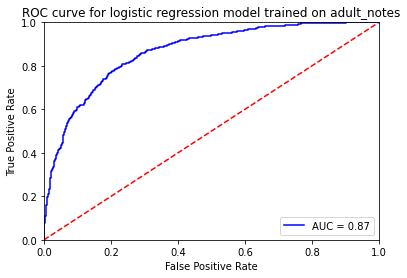

In [43]:
evaluate_model(model, x_test, y_test)

## F. Fairness metrics

### F.1 Setup functions and define definitions

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;width:100%}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-fymr{font-weight:bold;border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-fymr" style="width:20%">Fairness Property</th>
    <th class="tg-fymr" style="width:40%">Definition</th>
    <th class="tg-fymr" style="width:15%">Gap Name</th>
    <th class="tg-fymr" style="width:25%">Gap Equation</th>
  </tr>
  <tr>
    <td class="tg-0pky">Demographic parity</td>
    <td class="tg-0pky">$P(\hat{Y}=y) = P(\hat{Y} = \hat{y} | Z=z),&nbsp;&nbsp;\forall z \in Z $</td>
    <td class="tg-0pky">Parity Gap</td>
    <td class="tg-0pky">$\frac{TP_1 + FP_1}{N_1} - \frac{TP_2 + FP_2}{N_2}$</td>
  </tr>
  <tr>
    <td class="tg-0pky">Equality of opportunity<br>(positive class)</td>
    <td class="tg-0pky">$P(\hat{Y}=1 | Y=1) =&nbsp;&nbsp;P(\hat{Y}=1 | Y=1, Z=z), \forall z \in Z$</td>
    <td class="tg-0pky">Recall Gap</td>
    <td class="tg-0pky">$\frac{TP_1 }{TP_1+FN_1} - \frac{TP_2 }{TP_2 + FN_2}$</td>
  </tr>
  <tr>
    <td class="tg-0pky">Equality of opportunity<br>(negative class)</td>
    <td class="tg-0pky">$P(\hat{Y}=0 | Y=0) =&nbsp;&nbsp;P(\hat{Y}=0 | Y=0, Z=z), \forall z \in Z$</td>
    <td class="tg-0pky">Specificity Gap</td>
    <td class="tg-0pky">$\frac{TN_1 }{TN_1+FP_1} - \frac{TN_2 }{TN_2 + FP_2}$</td>
  </tr>
</table>

In [ ]:
def confusion_matrix(target, pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(pred)): 
        if target[i]==pred[i]==1:
            TP += 1
        if pred[i]==1 and target[i]!=pred[i]:
            FP += 1
        if target[i]==pred[i]==0:
            TN += 1
        if pred[i]==0 and target[i]!=pred[i]:
            FN += 1

    return(TP, FP, TN, FN)

In [53]:
def gap_metrics(tpr_dict: dict, pop1: str, pop2: str) -> dict:
    '''
    Calculates the parity gap, specificity gap, and recall gap 2 protected populations
    Inputs:
    tpr_dict: key = population, values = [TP, FP, TN, FN, N]
    pop1: name of population 1 of interest
    pop2: name of population 2 of interest 
    Output:
    parity_gap, recall_gap, specificity_gap
    '''
    # calculated gap for the first 2 populations
    # NOTE: gap can only be calculated between 2 populations
    # parity gap        : $\frac{TP_1 + FP_1}{N_1} - \frac{TP_2 + FP_2}{N_2}$
    # recall gap        : $\frac{TP_1 }{TP_1+FN_1} - \frac{TP_2 }{TP_2 + FN_2}$
    # spcificity gap    : 	$\frac{TN_1 }{TN_1+FP_1} - \frac{TN_2 }{TN_2 + FP_2}$

    # get tpr metrics of 2 populations of interest
    tpr_1 = tpr_dict[pop1]
    tpr_2 = tpr_dict[pop2]
    parity_gap = ((tpr_1[0] + tpr_1[1]) / (tpr_1[4]) - ((tpr_2[0] + tpr_2[1]) / (tpr_2[4])))
    recall_gap = ((tpr_1[0]) / (tpr_1[0] + tpr_1[3]) - (tpr_2[0]) / (tpr_2[0] + tpr_2[3]))
    specificity_gap = ((tpr_1[0]) / (tpr_1[0] + tpr_1[1]) - (tpr_2[0]) / (tpr_2[0] + tpr_2[1]))

    return parity_gap, recall_gap, specificity_gap

In [49]:
def get_tpr_dict(df: pd.DataFrame, protected_col:str, target_col:str, pred_col:str, thres:float):
    """
    Get tpr values (TP, FP, TN, FN, N) dict of all unique protected populations
    inputs:
    df : dataframe  
    protected_col: name of column in df corresponding to protected variable
    target_col: name of column in df corresponding to binary classification target, in {0, 1}
    pred_col: name of column in df corresponding to classifier prediction, in [0, 1]
    thres: decision threshold to round pred_col
    """
    # Calculate protected populations
    pops = df[protected_col].unique()

    # Get TPR values per population of interest
    tpr_dict = {}

    for pop in pops:
        df_pop = df.loc[df[protected_col] == pop]
        target = df_pop[target_col].values
        pred = df_pop[pred_col].values
        pred[pred > thres] = 1
        pred[pred <= thres] = 0

        # Calculate TPR (recall) for per pop
            # TP, FP, TN, FN, N
        TP, FP, TN, FN = confusion_matrix(target, pred)
        tpr_dict[pop] = [TP, FP, TN, FN, len(target)]

    return tpr_dict

In [54]:
def max_gap_multigroup(df, protected_col:str, target_col:str, pred_col:str, thres:float) -> dict:
    '''
    Calculates max gaps for a protected_col with potentially more than two unique values.
    Inputs:
    df: pandas dataframe
    protected_col: name of column in df corresponding to protected variable
    target_col: name of column in df corresponding to binary classification target, in {0, 1}
    pred_col: name of column in df corresponding to classifier prediction, in [0, 1]
    thres: decision threshold to round pred_col
    Output:
    Dictionary mapping str: [float], with each entry representing the gap in favor for a group.
    Ex: {
        'Medicare': [max_parity_gap, max_recall_gap, max_spcificity_gap],
        'Medicaid': [max_parity_gap, max_recall_gap, max_spcificity_gap],
        ...
    }
    '''

    # get tpr values for all protected populations
    tpr_dict = get_tpr_dict(df, protected_col, target_col, pred_col, thres)

    # Get max TPR gap per population
    gaps = {}

    for pop1 in pops:
        gaps[pop1] = [-np.inf, -np.inf, -np.inf]

    for pop2 in pops:
        # Don't calculate gap between same population
        if pop1 == pop2:
            continue
        
        parity_gap, recall_gap, specificity_gap = gap_metrics(tpr_dict, pop1, pop2)
        curr_gaps = gaps[pop1]

        # update parity_gap
        if abs(parity_gap) > abs(curr_gaps[0]):
            curr_gaps[0] = parity_gap
            gaps[pop_curr] = curr_gaps

        # update recall_gap
        if abs(recall_gap) > abs(curr_gaps[1]):
            curr_gaps[1] = recall_gap
            gaps[pop_curr] = curr_gaps
        
        # update specificity_gap
        if abs(specificity_gap) > abs(curr_gaps[2]):
            curr_gaps[2] = specificity_gap
            gaps[pop_curr] = curr_gaps

    return gaps


In [51]:
def stratified_sample(df, col: str):
    '''
    Returns a stratified sample of df with replacement (stratified by column), with the same number of rows as df.
    df: dataframe
    col: column to stratify by (eg. gender)
    '''
    # group_keys = False (doesn't create extra index column when grouping)
    grp = df.groupby(col, group_keys = False)

    return grp.apply(lambda x: x.sample(n = int(np.rint(len(x))), replace = True)).sample(frac=1).reset_index(drop = True)

In [63]:
from scipy.stats import sem, t
from scipy import mean

def get_mean_CI(data, confidence_level):
    """
    Return mean and confidence interval bounds

    inputs:
    - data: array of data with values of interest
    - confidence_level: desired confidence level (eg. 95%)
    - type: 
    """

    n = len(data)
    mean_val = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence_level) / 2, n - 1)

    lower_bound = mean_val - h
    upper_bound = mean_val + h

    return mean_val, lower_bound, upper_bound

### F.2 Calculate fairness given bootstrapped samples

In [60]:
# outputs
male_df = pd.DataFrame(columns=["parity_gap", "recall_gap", "specificity_gap"])
female_df = pd.DataFrame(columns=["parity_gap", "recall_gap", "specificity_gap"])

# Map y_pred to subject_id
y_pred_dict = {}
y_pred_dict.update(zip(test_df["subject_id"].values, y_pred))

# Stratify samples 1000 times --> generate gaps
    # TODO change number 
for i in range(10):
    strat_df = stratified_sample(test_df, 'gender')

    # get predictions for all subjects in sample
    strat_df["y_pred"] = [y_pred_dict[id] for id in strat_df["subject_id"].values]

    parity_gap, recall_gap, specificity_gap = gap_metrics(get_tpr_dict(strat_df,"gender", "mort_icu", "y_pred", 0.3), "M", "F")

    male_df = male_df.append({"parity_gap": parity_gap, "recall_gap": recall_gap, "specificity_gap": specificity_gap}, ignore_index = True)
    female_df = female_df.append({"parity_gap": -1 * parity_gap, "recall_gap": -1 * recall_gap, "specificity_gap": -1 * specificity_gap}, ignore_index = True)

,parity_gap,recall_gap,specificity_gap
0,-0.000389,0.023829,0.140175
1,-0.007434,-0.023203,0.239351


### F.3 Stats for gaps

In [65]:
# Report mean and 95% confidence interval values for gaps

print("Male parity gap")
mean_val, lower_bound, upper_bound = get_mean_CI(male_df["parity_gap"].values, 0.95)
print("mean: " + str(mean_val) + " confidence interval of 95%, from " + str(lower_bound) + " to " + str(upper_bound))


print("Male recall gap")
mean_val, lower_bound, upper_bound = get_mean_CI(male_df["recall_gap"].values, 0.95)
print("mean: " + str(mean_val) + " confidence interval of 95%, from " + str(lower_bound) + " to " + str(upper_bound))


print("Male specificity gap")
mean_val, lower_bound, upper_bound = get_mean_CI(male_df["specificity_gap"].values, 0.95)
print("mean: " + str(mean_val) + " confidence interval of 95%, from " + str(lower_bound) + " to " + str(upper_bound))

print("Female parity gap")
mean_val, lower_bound, upper_bound = get_mean_CI(female_df["parity_gap"].values, 0.95)
print("mean: " + str(mean_val) + " confidence interval of 95%, from " + str(lower_bound) + " to " + str(upper_bound))


print("Female recall gap")
mean_val, lower_bound, upper_bound = get_mean_CI(female_df["recall_gap"].values, 0.95)
print("mean: " + str(mean_val) + " confidence interval of 95%, from " + str(lower_bound) + " to " + str(upper_bound))


print("Female specificity gap")
mean_val, lower_bound, upper_bound = get_mean_CI(female_df["specificity_gap"].values, 0.95)
print("mean: " + str(mean_val) + " confidence interval of 95%, from " + str(lower_bound) + " to " + str(upper_bound))


# statistical significance of parity gap

t_test(male_df["parity_gap"].values, female_df["parity_gap"].values)

Male parity gap
mean: -0.003911731952298062 confidence interval of 95%, from -0.04866940029980836 to 0.04084593639521224
Male recall gap
mean: 0.00031274745248257435 confidence interval of 95%, from -0.29848903976703034 to 0.29911453467199545
Male specificity gap
mean: 0.18976306590134218 confidence interval of 95%, from -0.4403102689638114 to 0.8198364007664958
Female parity gap
mean: 0.003911731952298062 confidence interval of 95%, from -0.04084593639521224 to 0.04866940029980836
Female recall gap
mean: -0.00031274745248257435 confidence interval of 95%, from -0.29911453467199545 to 0.29848903976703034
Female specificity gap
mean: -0.18976306590134218 confidence interval of 95%, from -0.8198364007664958 to 0.4403102689638114
t=-1.570, p=0.257
Cannot reject null hypothesis (Ho = means are equal)
Cannot say that there is statistical difference between 2 populations


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  from ipykernel import kernelapp as app
